In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

import warnings
warnings.filterwarnings('ignore')

#系統操作、解壓縮檔案
import os
from zipfile import ZipFile

#機器學習
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV


# 設定 data_path
dir_data = './data/'

In [2]:
#安裝geopandas有許多坑，很容易error，可以參考 https://zhuanlan.zhihu.com/p/137628480，文中第3個方法
#地理資料相關
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries

from shapely import geos, geometry
from shapely.geometry import shape,LineString,Point,Polygon

import fiona
from fiona.crs import from_epsg,from_string

#繪圖相關
import folium
from folium import IFrame

#顏色相關
import seaborn as sns
import branca

In [3]:
#安裝道路分析 相關套件
import osmnx as ox
import networkx as nx

In [4]:
# GIS編碼轉換
def trans(gdf):
    gdf.crs = {'init' :'epsg:3824'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs({'init' :'epsg:4326'})
    return gdf
# 中文顯示
def utf2asc(s):
    return str(str(s).encode('ascii', 'xmlcharrefreplace'))[2:-1]
heading3 = """<h3>{}</h3>""".format

In [5]:
f_path = os.path.join(dir_data, 'GIS/捷運_1100406/MRT_1100406.shp')
print('Path of read in data: %s' % (f_path))

gdf_mrt = gpd.read_file(f_path,encoding='utf-8')

Path of read in data: ./data/GIS/捷運_1100406/MRT_1100406.shp


In [6]:
gdf_mrt['MRTCODE'].unique()

array(['中和新蘆線', '文湖線', '板南線', '淡水信義線', '機場捷運', '松山新店線', None, '貓空纜車',
       '新北投線', '綠線', '紅線', '橘線', '環狀線', '三鶯線', '小碧潭線'], dtype=object)

In [49]:
f_path = os.path.join(dir_data, 'GIS/捷運_1100406/捷運站經緯度.xlsx')
print('Path of read in data: %s' % (f_path))
MRT = pd.read_excel(f_path)


MRT_sub=MRT[MRT['station_name_tw'].isin(['景美','大坪林','七張','新店區公所','新店','小碧潭','南勢角','景安','永安市場','頂溪'])].reset_index(drop=True)

Path of read in data: ./data/GIS/捷運_1100406/捷運站經緯度.xlsx


In [31]:
MRT_sub.head(3)

,station_code,construction_id,station_name_tw,station_name_en,line_code,line_name,address,lat,lon,color
0,G01,G1,新店,Xindian,G,松山新店線,新北市新店區北宜路一段2號,24.957855,121.537584,#008659
1,G02,G2,新店區公所,Xindian District Office,G,松山新店線,新北市新店區北新路一段295號,24.967393,121.541310,#008659
2,G03,G3,七張,Qizhang,G,松山新店線,新北市新店區北新路二段150號,24.975169,121.542942,#008659


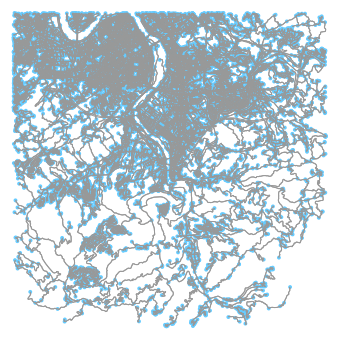

(<Figure size 474.732x432 with 1 Axes>, <AxesSubplot:>)

In [219]:
# https://geoffboeing.com/2016/11/osmnx-python-street-networks/
# drive, drive_service, walk, bike, all, all_private
site_lat = 24.956544
site_lon = 121.536432
G = ox.graph_from_point((site_lat, site_lon), dist=7000, network_type='all')
ox.plot_graph(G)

In [220]:
G = ox.project_graph(G) # 投影
gdf1,gdf2=ox.graph_to_gdfs(G)

meters_per_minute = 30 * 1000 / 60 # 每小時30公里
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [221]:
gdf1

,y,x,osmid,highway,ref,lon,lat,geometry
2318925824,2.767292e+06,349855.771457,2318925824,NaN,NaN,121.512036,25.013727,POINT (349855.771 2767292.154)
2320433152,2.767276e+06,349782.937183,2320433152,NaN,NaN,121.511316,25.013569,POINT (349782.937 2767275.508)
2318925826,2.766516e+06,350572.717858,2318925826,NaN,NaN,121.519223,25.006788,POINT (350572.718 2766515.716)
2318925827,2.767144e+06,349807.632270,2318925827,NaN,NaN,121.511575,25.012383,POINT (349807.632 2767143.846)
2318925828,2.767119e+06,349813.086240,2318925828,NaN,NaN,121.511632,25.012162,POINT (349813.086 2767119.362)
...,...,...,...,...,...,...,...,...
2320433143,2.767564e+06,349732.752677,2320433143,NaN,NaN,121.510788,25.016166,POINT (349732.753 2767563.742)
2320433144,2.767175e+06,350510.397472,2320433144,NaN,NaN,121.518535,25.012731,POINT (350510.397 2767174.745)
2320433145,2.767682e+06,350179.199866,2320433145,NaN,NaN,121.515198,25.017275,POINT (350179.200 2767681.670)
2318925813,2.766958e+06,349812.171141,2318925813,NaN,NaN,121.511641,25.010705,POINT (349812.171 2766957.964)


In [224]:
trip_times = [1, 2, 4] #分鐘
# 給定顏色
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)


for i in range(MRT_sub.shape[0]):
    if i == 0:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0_base = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1_base = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2_base = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
        
    else:
        if MRT_sub['station_name_tw'][i]=='小碧潭':
            center_node = 2216662234
        else:
            center_node=gdf1[(gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2==min((gdf1.lat-MRT_sub.lat[i])**2+(gdf1.lon-MRT_sub.lon[i])**2)].index[0]#最近點
        print(1)

        node_colors = {}
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color # 抵達的node給顏色

        nc = [node_colors[node] if node in node_colors else 'blue' for node in G.nodes()]
        gdf1['color']=nc

        gdf_sub0=gdf1.loc[gdf1.color.isin(iso_colors[0:3]),:]
        gdf_sub1=gdf1.loc[gdf1.color.isin(iso_colors[1:3]),:]
        gdf_sub2=gdf1.loc[gdf1.color.isin(iso_colors[2:3]),:]

        sub_convex0=geometry.MultiPoint(list(zip(gdf_sub0.geometry.x,gdf_sub0.geometry.y))).convex_hull
        sub_convex1=geometry.MultiPoint(list(zip(gdf_sub1.geometry.x,gdf_sub1.geometry.y))).convex_hull
        sub_convex2=geometry.MultiPoint(list(zip(gdf_sub2.geometry.x,gdf_sub2.geometry.y))).convex_hull
        
        sub_convex0 = gpd.GeoDataFrame({'geometry': sub_convex0, 'df':[0]})
        sub_convex1 = gpd.GeoDataFrame({'geometry': sub_convex1, 'df':[1]})
        sub_convex2 = gpd.GeoDataFrame({'geometry': sub_convex2, 'df':[2]})
    
        sub_convex0_base = gpd.overlay(sub_convex0_base,sub_convex0,  how='union')
        sub_convex1_base = gpd.overlay(sub_convex1_base,sub_convex1,  how='union')
        sub_convex2_base = gpd.overlay(sub_convex2_base,sub_convex2,  how='union')
        
        sub_convex0_base['df']=0
        sub_convex0_base = sub_convex0_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex1_base['df']=1
        sub_convex1_base = sub_convex1_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
        
        sub_convex2_base['df']=2
        sub_convex2_base = sub_convex2_base.dissolve(by=['df']).reset_index().loc[:,['df','geometry']]
    
    print(2)

sub_convex0_base = gpd.GeoDataFrame(sub_convex0_base,crs = gdf1.crs)
sub_convex1_base = gpd.GeoDataFrame(sub_convex1_base,crs = gdf1.crs)
sub_convex2_base = gpd.GeoDataFrame(sub_convex2_base,crs = gdf1.crs)

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


<AxesSubplot:>

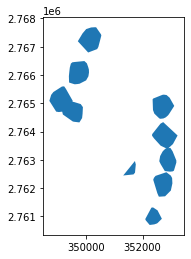

In [225]:
sub_convex2_base.plot()

In [226]:
f_path = os.path.join(dir_data, 'Real estate valuation data set.xlsx')
print('Path of read in data: %s' % (f_path))

df = pd.read_excel(f_path)

Path of read in data: ./data/Real estate valuation data set.xlsx


In [227]:
print(np.array(df.columns))
df.columns = ['No','Trans_Date','Age','D2MRT','n_convenience_stores','lat','lon','Y']
print(np.array(df.columns))

['No' 'X1 transaction date' 'X2 house age'
 'X3 distance to the nearest MRT station'
 'X4 number of convenience stores' 'X5 latitude' 'X6 longitude'
 'Y house price of unit area']
['No' 'Trans_Date' 'Age' 'D2MRT' 'n_convenience_stores' 'lat' 'lon' 'Y']


In [228]:
# 查看資料大小
print('Data shape: ', df.shape)

Data shape:  (414, 8)


In [229]:
# 查看資料內容
def columns_type(df_data):
    dtype_df = df_data.dtypes.reset_index()
    dtype_df.columns = ['Columns', 'Type']
    dtype_df_count = dtype_df.groupby(['Type'])['Columns'].count().reset_index()
    for t, n in zip(dtype_df_count.Type, dtype_df_count.Columns):
        print('類型 : ',t,'\n')
        print('  個數 : ',n,'\n')
        print('  ',list(dtype_df[dtype_df.Type==t].Columns),'\n')
        print('-----------------------------------------------\n')
        
def object_check(df_data):    
    object_type = df_data.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).reset_index() 
    object_type.columns = ["Column", "Unique Count"]
    display(object_type.head(10))        
        
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
    
columns_type(df)
object_check(df)
print('\n')
print('Data na_check')
na_check(df)

類型 :  int64 

  個數 :  2 

   ['No', 'n_convenience_stores'] 

-----------------------------------------------

類型 :  float64 

  個數 :  6 

   ['Trans_Date', 'Age', 'D2MRT', 'lat', 'lon', 'Y'] 

-----------------------------------------------



,Column,Unique Count




Data na_check


,Missing Ratio


In [230]:
df['Year'] = df['Trans_Date'].astype('int')
df['Month'] = (((df['Trans_Date'] - df['Trans_Date'].astype('int')) * 12) + 1).astype('int')

In [231]:
df_train = df.copy()

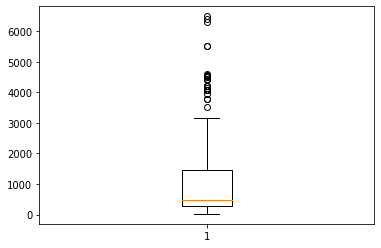

In [232]:
plt.boxplot(df_train['D2MRT'])
plt.show()

In [233]:
df_train['D2MRT'][df_train['D2MRT']>2000]=2000

In [234]:
#想畫顏色的變數
variable='Y'

#設定色階
df_train['id']=df_train.index
color=df_train.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8
print(p)

colorscale = branca.colormap.linear.YlOrRd_09.scale(low, high)
#colorscale = branca.colormap.linear.YlGnBu_09.scale(low, 0.4)
colorscale

14.6875


In [235]:
df_train['color'] = color.apply(lambda x : colorscale(x))

In [352]:
f_path = os.path.join(dir_data, 'GIS/重劃區/重劃區.xlsx')
print('Path of read in data: %s' % (f_path))
re_location = pd.read_excel(f_path)

Path of read in data: ./data/GIS/重劃區/重劃區.xlsx


In [353]:
re_location =re_location.loc[ (-(re_location['year']>100)) & (re_location['city'].isin(['新北市'])) \
                & ((re_location['name'].apply(lambda x:'新店' in x)) | (re_location['name'].apply(lambda x:'中和' in x)) \
                   | (re_location['name'].apply(lambda x:'永和' in x)) | (re_location['name'].apply(lambda x:'寶橋' in x)) ) \
                             ,:].reset_index(drop=True)

In [354]:
re_location

,year,city,name,casetypes,condition,lat,lon
0,NaN,新北市,新店禾豐第二期自辦市地重劃區,B,辦理完成,24.935564,121.510795
1,NaN,新北市,新店華城秀岡三期自辦市地重劃區,B,辦理完成,24.916239,121.494472
2,NaN,新北市,新店華城秀岡一期自辦市地重劃區,B,辦理完成,24.912492,121.501415
3,NaN,新北市,新店禾豐第三期自辦市地重劃區,B,辦理完成,24.934337,121.509754
4,NaN,新北市,新店碧潭大橋北側(F單元),A,規劃中,24.964916,121.530459
5,NaN,新北市,台北縣(第五期)新店大坪林,B,辦理完成,24.972117,121.536894
6,NaN,新北市,中和灰磘,A,規劃中,24.985181,121.482363
7,NaN,新北市,新店十四張(B單元),A,規劃中,24.984509,121.529770
8,NaN,新北市,新店禾豐第一期自辦市地重劃區,B,辦理完成,24.936810,121.510348
9,NaN,新北市,第二期永和和平市地重劃區,B,辦理完成,25.005802,121.508277


In [355]:
geom = [Point(data.lon,data.lat) for idx,data in re_location.iterrows()]
crs = {'init': 'epsg:4326'}
re_location = gpd.GeoDataFrame(re_location, crs=crs, geometry=geom)
re_location = re_location.to_crs(epsg=3826)

In [356]:
re_location_buffer = re_location.copy()
re_location_buffer['geometry'] = re_location_buffer.buffer(500)
re_location_buffer = re_location_buffer.dissolve(by='city').reset_index()

In [236]:
f_path = os.path.join(dir_data, 'GIS/村里邊界/VILLAGE_MOI_1090423.shp')
print('Path of read in data: %s' % (f_path))

gdf = gpd.read_file(f_path,encoding='utf-8')
gdf=gdf.loc[:,['COUNTYNAME','TOWNNAME','VILLNAME','geometry']]
gdf=trans(gdf)
print(gdf.shape)
gdf=gdf.dropna().reset_index(drop=True)
gdf.columns=['縣市','行政區','村里','geometry']
print(gdf.shape)
gdf.head(5)

Path of read in data: ./data/GIS/村里邊界/VILLAGE_MOI_1090423.shp
(7965, 4)
(7760, 4)


,縣市,行政區,村里,geometry
0,高雄市,林園區,中門里,"POLYGON ((120.36772 22.49564, 120.36427 22.498..."
1,高雄市,林園區,港埔里,"POLYGON ((120.37325 22.49123, 120.37147 22.492..."
2,高雄市,旗津區,上竹里,"POLYGON ((120.28976 22.57317, 120.28577 22.577..."
3,高雄市,旗津區,中興里,"POLYGON ((120.30320 22.55568, 120.30284 22.557..."
4,連江縣,南竿鄉,津沙村,"POLYGON ((119.91684 26.14109, 119.91683 26.141..."


In [237]:
gdf_boundry=gdf.loc[ ( (gdf['縣市'].isin(['臺北市','新北市'])) & (gdf['行政區'].isin(['新店區','中和區','永和區','文山區']))), :]

gdf_boundry=gdf_boundry.dissolve(by='行政區').reset_index()
gdf_boundry

,行政區,geometry,縣市,村里
0,中和區,"POLYGON ((121.46811 24.99369, 121.46806 24.993...",新北市,華新里
1,文山區,"POLYGON ((121.59606 25.00431, 121.59613 25.004...",臺北市,樟新里
2,新店區,"POLYGON ((121.56652 24.90373, 121.56650 24.903...",新北市,龜山里
3,永和區,"POLYGON ((121.50822 25.00247, 121.50830 25.002...",新北市,智光里


In [238]:
f_path = os.path.join(dir_data, 'GIS/所得/2012年村里所得資料.csv')
print('Path of read in data: %s' % (f_path))
Income = pd.read_csv(f_path)

Income = Income[-Income['村里'].isin(['合計','其他'])].reset_index(drop=True)
Income.rename(columns={'鄉鎮市區':'行政區'},inplace=True)

Income['村里']=Income['村里'].apply(lambda x:x.replace('五峰里','五峯里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('灰\U000fc355里','灰磘里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('瓦\U000fc355里','瓦磘里'))
Income['村里']=Income['村里'].apply(lambda x:x.replace('新\U000fffb4里','新廍里'))

Path of read in data: ./data/GIS/所得/2012年村里所得資料.csv


In [239]:
gdf_sub = gdf.loc[ ( (gdf['縣市'].isin(['臺北市','新北市'])) & (gdf['行政區'].isin(['新店區','中和區','永和區','文山區']))), :].reset_index(drop=True)

In [240]:
gdf_sub[-(gdf_sub['縣市'] + gdf_sub['行政區']+ gdf_sub['村里']).isin(Income['縣市'] + Income['行政區']+ Income['村里'])]

,縣市,行政區,村里,geometry


In [241]:
#Income[(Income['縣市'] + Income['行政區']).isin(['新北市永和區'])]['村里'].unique()

In [242]:
Income['site'] = Income['縣市'] + Income['行政區']+ Income['村里']
gdf_sub['site'] = gdf_sub['縣市'] + gdf_sub['行政區']+ gdf_sub['村里']

In [243]:
gdf_final = pd.merge(gdf_sub,Income)

In [244]:
gdf_final.head(2)

,縣市,行政區,村里,geometry,site,納稅單位,綜合所得總額,平均數,中位數,第一分位數,第三分位數,標準差,變異係數
0,新北市,新店區,龜山里,"POLYGON ((121.54472 24.91309, 121.54504 24.913...",新北市新店區龜山里,430,312115,726,475,313,863,1108.22,152.68
1,新北市,新店區,廣興里,"POLYGON ((121.53402 24.91970, 121.53403 24.919...",新北市新店區廣興里,299,202586,678,517,317,791,635.52,93.80


In [245]:
site=['基隆市','新北市', '台北市','桃園市','新竹縣','新竹市','苗栗縣','台中市','彰化縣','南投縣',
      '雲林縣','嘉義縣','嘉義市','台南市',
      '高雄市','屏東縣','宜蘭縣','花蓮縣','台東縣',
      '澎湖縣','金門縣','連江縣']

site_colors={'基隆市':'#6e5e4c','新北市':'#6e5e4c', '台北市':'#6e5e4c',
            '桃園市':'#968278','新竹縣':'#968278','新竹市':'#968278','苗栗縣':'#968278',
            '台中市':'#6e5e4c','彰化縣':'#6e5e4c','南投縣':'#6e5e4c','澎湖縣':'#6e5e4c','金門縣':'#6e5e4c','連江縣':'#6e5e4c',
            '雲林縣':'#968278','嘉義縣':'#968278','嘉義市':'#968278','台南市':'#968278',
            '高雄市':'#6e5e4c','屏東縣':'#6e5e4c',
            '宜蘭縣':'#968278','花蓮縣':'#968278','台東縣':'#968278'}

#想畫顏色的變數
variable='中位數'

#設定色階
gdf_final['id']=gdf_final.index
color=gdf_final.set_index('id')[variable]

high=round(color.max(),1)
low=color.min()
p=high/8
print(p)

colorscale = branca.colormap.linear.YlOrRd_09.scale(low, high)
#colorscale = branca.colormap.linear.YlGnBu_09.scale(low, 0.4)
colorscale

159.375


In [246]:
# 顏色 style
def style_function(feature):
    colors = color.get(int(feature['id']), None)
    site_color=site_colors.get(feature['properties']['縣市'])
    return {
        'fillOpacity': 0.5,
        'weight': 1,
        'color':site_color,
        'fillColor': '#fff' if colors is None else colorscale(colors)
    }

In [247]:
# 篩選縣市
site2=site[1:3]
print(site2)

['新北市', '台北市']


In [248]:
# 各車站定位
台北車站=[25.047741, 121.517384]
中壢車站=[24.953737, 121.225607]
台中車站=[24.137264, 120.686669]
嘉義車站=[23.479119, 120.441138]

In [249]:
# 設定圖例
colormap=colorscale.to_step(index=[0, p*1, p*2, p*3, p*4,p*5,p*6,p*7,p*8])
#colormap.caption ='The Number of Loss Member'
colormap.caption ='Income'
#colormap.caption ='Average Consumption'

In [ ]:
color='#FFFF37', # Circle 顏色
    radius=7000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度

In [359]:
# 設定地圖一開始顯示的中心與大小
mm=folium.Map(location=台北車站,zoom_start=12,tiles="Cartodb Positron")

#行政區邊界
dis=1
if dis==1:
    folium.GeoJson(
        gdf_boundry,
        style_function = lambda x: {
            'color': '#642100',
            'weight': 4,
            'fillOpacity': 0.2
        },
        name='行政區邊界').add_to(mm)

# 重劃區
re_loc=1
if re_loc==1:
    folium.GeoJson(
        re_location_buffer,
        style_function = lambda x: {
            'color': '#408080',
            'weight': 6,
            'dash_array':'10',
            'fillOpacity': 0
        },
        name='re_loc').add_to(mm)

    
# 所得
folium.GeoJson(
    gdf_final[['geometry','縣市','行政區','村里','平均數','中位數','標準差']],
    name='所得', 
    style_function=style_function,
    highlight_function=lambda x: {'weight':3, 
                                    'color':site_colors.get(x['properties']['縣市']),
                                    'fillOpacity':0.75},
    smooth_factor=2.0,
    tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','平均數','中位數'],
                                                aliases=['縣市','行政區','村里','平均數','中位數'], 
                                                labels=True, 
                                                sticky=True,
                                                toLocaleString=True
                                                )
).add_to(mm)    
    
    


#捷運路線
folium.GeoJson(
        gdf_mrt.loc[gdf_mrt['MRTCODE'].isin(['松山新店線','小碧潭線','中和新蘆線']),:],
        
        name='捷運路線').add_to(mm)

#捷運站
if 1==1:
    #MRT_cluster = MarkerCluster(name='MRT').add_to(mm)
    fg1=folium.FeatureGroup(name='MRT', show=True)
    for i in range(MRT.shape[0]):
        if MRT.line_code[i] in ['G','O']:
            iframe = IFrame(html=heading3(utf2asc(MRT.station_name_tw[i])),width=250,height=50)
            popup = folium.Popup(iframe)
            folium.Marker(location=[MRT.lat[i], MRT.lon[i]],
                           popup=popup,
                           icon=folium.Icon(icon='train',
                                            color='black',
                                            icon_color=MRT.color[i],
                                            prefix='fa')).add_to(fg1)
    mm.add_child(fg1)

#距離遠近
if 1==1:
    fg2=folium.FeatureGroup(name='遠', show=True)
    fg3=folium.FeatureGroup(name='中', show=True)
    fg4=folium.FeatureGroup(name='近', show=True)

    folium.Choropleth(geo_data=sub_convex0_base,fill_color=iso_colors[0],fill_opacity=0.15).add_to(fg2)
    mm.add_child(fg2)
    folium.Choropleth(geo_data=sub_convex1_base,fill_color=iso_colors[1],fill_opacity=0.175).add_to(fg3)
    mm.add_child(fg3)
    folium.Choropleth(geo_data=sub_convex2_base,fill_color=iso_colors[2],fill_opacity=0.2).add_to(fg4)
    mm.add_child(fg4)

#道路交叉口
if 1==0:
    fg5=folium.FeatureGroup(name='道路交叉口', show=True)
    for idx,data in gdf1.iterrows():
        if idx==center_node:
            folium.Circle([data.geometry.y,data.geometry.x],radius=100,color='yellow',fill=True).add_to(fg5)
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
        else:
            folium.Circle([data.geometry.y,data.geometry.x],radius=20,color=data.color).add_to(fg5)
    mm.add_child(fg5)    

#房屋位置
if 1==1:
    num=df_train.shape[0]
    lat=np.array(df_train["lat"][0:num])
    lon=np.array(df_train["lon"][0:num])
    data1=[[lat[i],lon[i],1] for i in range(num)]
    fg1=folium.FeatureGroup(name='房屋(點)', show=True)
    for i in range(num):
        folium.Circle(location=[data1[i][0],data1[i][1]],
        color=df_train['color'][i], # Circle 顏色
        radius=25, # Circle 寬度
        fill=True, # 填滿中間區域
        fill_opacity=0.7 # 設定透明度
        ).add_to(fg1)
    mm.add_child(fg1)    
    
    
colormap.add_to(mm)

folium.LayerControl().add_to(mm)

In [360]:
mm

In [ ]:
"Cartodb Positron"'Stamen Toner'

In [ ]:
mm=folium.Map(location=台北車站,zoom_start=11,tiles="Cartodb Positron")
dis=1
if dis==1:
    folium.GeoJson(
        gdf_boundry,
        style_function = lambda x: {
            'color': '#642100',
            'weight': 4,
            'fillOpacity': 0.2
        },
        name='行政區邊界').add_to(mm)
    
    
for i in range(TLW.shape[0]):
    if TLW.type[i]==0:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='orange')).add_to(mm)
    '''
    elif TLW.type[i]==2:
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='pink')).add_to(mm)
    else:  
        iframe = IFrame(html=heading3(utf2asc(TLW.name[i])),width=250,height=50)
        popup = folium.Popup(iframe)
        folium.Marker(location=[TLW.lat[i], TLW.lon[i]],
                       popup=popup,
                       icon=folium.Icon(icon='info-sign',
                                        color='gray')).add_to(mm)
                                        '''


df03=df02.loc[(df02.site.isin(['1A01'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg1=folium.FeatureGroup(name='南崁店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#EA0000', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg1)
mm.add_child(fg1)
#HeatMap(data1,radius=8,name='南崁店(熱力圖)').add_to(mm)


df03=df02.loc[(df02.site.isin(['1A07'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg2=folium.FeatureGroup(name='內湖店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#0066CC', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg2)
mm.add_child(fg2)
#HeatMap(data1,radius=8,name='內湖店(熱力圖)').add_to(mm)

'''
df03=df02.loc[(df02.site.isin(['1A16'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg3=folium.FeatureGroup(name='新竹店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#00A600', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg3)
mm.add_child(fg3)
#HeatMap(data1,radius=8,name='新竹店(熱力圖)').add_to(mm)
'''

df03=df02.loc[(df02.site.isin(['1A09'])),:].reset_index(drop=True)
num=df03.shape[0]
lat=np.array(df03["lat"][0:num])
lon=np.array(df03["lon"][0:num])
data1=[[lat[i],lon[i],1] for i in range(num)]
fg4=folium.FeatureGroup(name='士林店(點)', show=True)
for i in range(num):
    folium.Circle(location=[data1[i][0],data1[i][1]],
    color='#00A600', # Circle 顏色
    radius=25, # Circle 寬度
    fill=True, # 填滿中間區域
    fill_opacity=0.7 # 設定透明度
    ).add_to(fg4)
mm.add_child(fg4)
#HeatMap(data1,radius=8,name='士林店(熱力圖)').add_to(mm)


fg5=folium.FeatureGroup(name='南崁店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A01南崁店'])].lat.values[0],TLW[TLW.name.isin(['1A01南崁店'])].lon.values[0]],
    color='#FFFF37', # Circle 顏色
    radius=9000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg5)
mm.add_child(fg5)

fg6=folium.FeatureGroup(name='內湖店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A07內湖店'])].lat.values[0],TLW[TLW.name.isin(['1A07內湖店'])].lon.values[0]],
    color='#FFFF37', # Circle 顏色
    radius=7000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg6)
mm.add_child(fg6)

fg7=folium.FeatureGroup(name='士林店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A09士林店'])].lat.values[0],TLW[TLW.name.isin(['1A09士林店'])].lon.values[0]],
    color='#FFFF37', # Circle 顏色
    radius=7000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg7)
mm.add_child(fg7)

fg8=folium.FeatureGroup(name='中和店(半徑)', show=True)
folium.Circle(location=[TLW[TLW.name.isin(['1A17中和店'])].lat.values[0],TLW[TLW.name.isin(['1A17中和店'])].lon.values[0]],
    color='#FF0080', # Circle 顏色
    radius=7000, # Circle 寬度
    fill=False, # 填滿中間區域
    weight = 6,
    dash_array='10',
    fill_opacity=1 # 設定透明度
).add_to(fg8)
mm.add_child(fg8)

folium.LayerControl().add_to(mm)


In [ ]:
def get_little():
    lon=float(input('請輸入店點經度 : '))
    lat=float(input('請輸入店點緯度 : '))
    geom=[Point(lon,lat)]
    crs = {'init': 'epsg:4326'}
    gdf_little = gpd.GeoDataFrame(pd.DataFrame({'Name':['TLW_little']}), crs=crs, geometry=geom)
    return gdf_little

def trans(gdf):
    gdf.crs = {'init' :'epsg:4326'} # 避免資料沒設，這邊再重新給一次
    gdf=gdf.to_crs(epsg=3826)
    return gdf

In [ ]:
gdf_little=get_little()
gdf_little=trans(gdf_little)

gdf_little_buffer=gdf_little.copy()
radius=float(input('請輸入半徑(公尺) : '))
gdf_little_buffer['geometry']=gdf_little_buffer.buffer(radius)

In [ ]:
for s in site2:
    folium.GeoJson(
        gdf_final[gdf_final['縣市']==s][['geometry','縣市','行政區','村里','平均數','中位數','標準差']],
        name='所得', 
        style_function=style_function,
        highlight_function=lambda x: {'weight':3, 
                                        'color':site_colors.get(x['properties']['縣市']),
                                        'fillOpacity':0.75},
        smooth_factor=2.0,
        tooltip=folium.features.GeoJsonTooltip(fields=['縣市','行政區','村里','平均數','中位數'],
                                                  aliases=['縣市','行政區','村里','平均數','中位數'], 
                                                  labels=True, 
                                                  sticky=True,
                                                  toLocaleString=True
                                                 )
    ).add_to(mm)